<a href="https://colab.research.google.com/github/CSID-DGU/2021-1-OSSP1-Debugger-4/blob/autoencoder/CNN_AUTOENCODER_ver_FID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 라이브러리 설정
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import cv2
import gc
import glob

from tensorflow.keras.layers import Reshape

# 랜덤 시드 고정
SEED=2021
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
minsu = glob.glob('./drive/MyDrive/videoimage3/*.png')
test_minsu = []
for _ in range(0,len(minsu)):
  img = cv2.imread(minsu[_])
  img = cv2.resize(img,(64,64))
  test_minsu.append(img.astype("float32")/255.0)
  
test_minsu = np.array(test_minsu)

print(test_minsu.shape)

(1912, 64, 64, 3)


In [4]:
# 오토인코더 모델 정의
def Autoencoder():
  #model = Sequnetial()

  X = tf.keras.layers.Input(shape=[64,64,3])

  #Encoder
  H = tf.keras.layers.Conv2D(32,(4,4),(2,2),activation='relu',padding='same')(X)
  H = tf.keras.layers.Conv2D(32*2,(4,4), (2,2),activation='relu',padding='same')(H)
  H = tf.keras.layers.Conv2D(32*4, (4,4),(2,2),activation='relu',padding='same')(H)
  H = tf.keras.layers.Conv2D(32*8, (4,4),(2,2),activation='relu',padding='same')(H)


  pool_tmp = H.shape.as_list()
  pool_tmp=pool_tmp[1:]
  

  #Fully-Connected
  H = tf.keras.layers.Flatten()(H)
  flatten_tmp=H.shape.as_list()
  flatten_tmp=flatten_tmp[1]
  H = tf.keras.layers.Dense(300,activation='relu')(H)
  H = tf.keras.layers.Dense(flatten_tmp,activation='relu')(H)
  H = Reshape(pool_tmp)(H)


  #Decoder
  H = tf.keras.layers.Conv2DTranspose(32*4,(2,2),strides=(2,2),padding='same',activation='relu')(H)
  H = tf.keras.layers.Conv2DTranspose(32*2,(2,2),strides=(2,2),padding='same',activation='relu')(H)
  H = tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding='same',activation='relu')(H)
  H = tf.keras.layers.Conv2DTranspose(3,(2,2),strides=(2,2),padding='same',activation='sigmoid')(H)

  model = tf.keras.models.Model(X,H)
  model.compile(optimizer='adam',loss='mean_squared_error', metrics=['acc'])

  return model

ae_model = Autoencoder()
ae_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        1568      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        32832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         131200    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         524544    
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 300)               122910

In [6]:
# 오토인코더 모델 학습
history = ae_model.fit(test_minsu,
                       test_minsu,
                       batch_size=8,
                       epochs=20,
                       verbose=1,
                       )


Epoch 1/20
239/239 [==============================] - 24s 99ms/step - loss: 0.0108 - acc: 0.8704
Epoch 2/20
239/239 [==============================] - 24s 101ms/step - loss: 0.0052 - acc: 0.9025
Epoch 3/20
239/239 [==============================] - 24s 101ms/step - loss: 0.0038 - acc: 0.9134
Epoch 4/20
239/239 [==============================] - 24s 99ms/step - loss: 0.0030 - acc: 0.9209
Epoch 5/20
239/239 [==============================] - 24s 100ms/step - loss: 0.0025 - acc: 0.9264
Epoch 6/20
239/239 [==============================] - 24s 99ms/step - loss: 0.0023 - acc: 0.9305
Epoch 7/20
 32/239 [===>..........................] - ETA: 20s - loss: 0.0021 - acc: 0.9346

KeyboardInterrupt: ignored

In [7]:
#테스트 데이터 Prediction
ae_images = ae_model.predict(test_minsu)
ae_images.shape

(1912, 64, 64, 3)

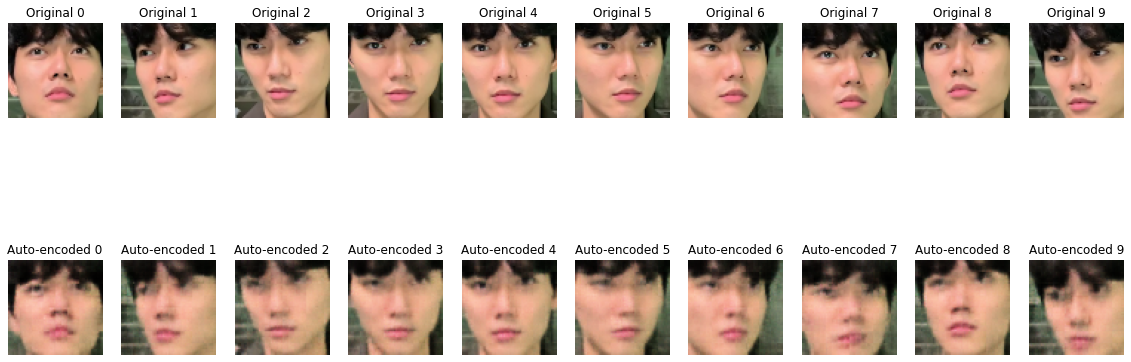

In [9]:
#이미지 출력
num = 10 
plt.figure(figsize=(20,8))
for i in range(10):
    # 원본 이미지
    ax = plt.subplot(2, num, i+1)
    plt.imshow(cv2.cvtColor(test_minsu[i*50], cv2.COLOR_BGR2RGB).reshape((64,64,3)))
    plt.title("Original %s" % str(i))
    plt.axis('off')
    
    # 복원 이미지
    ax = plt.subplot(2, num, i+num+1)
    plt.imshow(cv2.cvtColor(ae_images[i*50], cv2.COLOR_BGR2RGB).reshape((64,64,3)))
    plt.title("Auto-encoded %s" % str(i))
    plt.axis('off')
    
plt.show()